In [1]:
import pandas as pd
import csv
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures

# First lockdown 03/20/2020

Load data and convert the date to datetime

In [2]:
df = pd.read_csv('./pt/cases_pt.csv')
df['date'] = pd.to_datetime(df['date'])
df.tail(5)

,name,region,date,value,value_daily
703,cases,QC,2021-12-27,556731,10463
704,cases,QC,2021-12-28,570120,13389
705,cases,QC,2021-12-29,585527,15407
706,cases,QC,2021-12-30,604238,18711
707,cases,QC,2021-12-31,622836,18598


Set start date and end date for first lockdown

In [3]:
start_date = '2020-02-19'
end_date = '2020-04-20'
period = (df['date'] > start_date) & (df['date'] <= end_date)
df = df.loc[period]
df

,name,region,date,value,value_daily
27,cases,QC,2020-02-20,0,0
28,cases,QC,2020-02-21,0,0
29,cases,QC,2020-02-22,0,0
30,cases,QC,2020-02-23,0,0
31,cases,QC,2020-02-24,0,0
...,...,...,...,...,...
83,cases,QC,2020-04-16,14861,882
84,cases,QC,2020-04-17,15722,861
85,cases,QC,2020-04-18,16555,833
86,cases,QC,2020-04-19,17241,686


set the cutoff as the first lockdown

In [4]:
cutoff = datetime.strptime('2020-03-20', "%Y-%m-%d")
df['x_value'] = df['date'] - cutoff
df['x_value'] = df['x_value'].astype('timedelta64[D]')
df

,name,region,date,value,value_daily,x_value
27,cases,QC,2020-02-20,0,0,-29.0
28,cases,QC,2020-02-21,0,0,-28.0
29,cases,QC,2020-02-22,0,0,-27.0
30,cases,QC,2020-02-23,0,0,-26.0
31,cases,QC,2020-02-24,0,0,-25.0
...,...,...,...,...,...,...
83,cases,QC,2020-04-16,14861,882,27.0
84,cases,QC,2020-04-17,15722,861,28.0
85,cases,QC,2020-04-18,16555,833,29.0
86,cases,QC,2020-04-19,17241,686,30.0


The date before lockdown

In [5]:
df['lockdown'] = None
before_lockdown = df['x_value'] < 0
after_lockdown = df['x_value'] >= 0
df.loc[before_lockdown, 'lockdown'] = 0
df.loc[after_lockdown, 'lockdown'] = 1
df

,name,region,date,value,value_daily,x_value,lockdown
27,cases,QC,2020-02-20,0,0,-29.0,0
28,cases,QC,2020-02-21,0,0,-28.0,0
29,cases,QC,2020-02-22,0,0,-27.0,0
30,cases,QC,2020-02-23,0,0,-26.0,0
31,cases,QC,2020-02-24,0,0,-25.0,0
...,...,...,...,...,...,...,...
83,cases,QC,2020-04-16,14861,882,27.0,1
84,cases,QC,2020-04-17,15722,861,28.0,1
85,cases,QC,2020-04-18,16555,833,29.0,1
86,cases,QC,2020-04-19,17241,686,30.0,1


The date after lockdown

In [6]:
before = df[df['lockdown'] == 0]

X_before = np.array(before['x_value'] * -1)
X1 = sm.add_constant(X_before)
y_before = before['value_daily']
before = sm.WLS(y_before, X1).fit()
before_p = before.fittedvalues
print(before.summary())

                            WLS Regression Results                            
Dep. Variable:            value_daily   R-squared:                       0.449
Model:                            WLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     22.04
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           6.92e-05
Time:                        20:27:54   Log-Likelihood:                -49.957
No. Observations:                  29   AIC:                             103.9
Df Residuals:                      27   BIC:                             106.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0911      0.535      5.775      0.0

The date after lockdown

In [7]:
after = df[df['lockdown']==1]

X_after = np.array(after['x_value'])
X2 = sm.add_constant(X_after)
y_after = after['value_daily']
after = sm.WLS(y_after, X2).fit()
after_p = after.fittedvalues
print(after.summary())

                            WLS Regression Results                            
Dep. Variable:            value_daily   R-squared:                       0.756
Model:                            WLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     93.19
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.03e-10
Time:                        20:27:54   Log-Likelihood:                -200.46
No. Observations:                  32   AIC:                             404.9
Df Residuals:                      30   BIC:                             407.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.2841     45.359      4.019      0.0

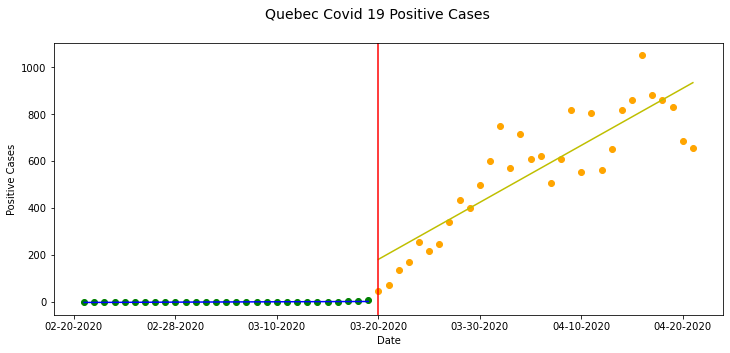

In [8]:
fig, ax = fig, (ax1) = plt.subplots(1,1, figsize=(12,5))

ax.scatter(X1[:,1]*-1, y_before, color = "g")
ax.plot(X1[:,1]*-1, before_p, color = 'b')
ax.scatter(X2[:,1], y_after, color = 'orange')
ax.plot(X2[:,1], after_p, color = 'y')
plt.axvline(0, color='r')


plt.xticks([-30,-20,-10,0,10,20,30],['02-20-2020', '02-28-2020','03-10-2020','03-20-2020','03-30-2020','04-10-2020','04-20-2020'])

fig.suptitle('Quebec Covid 19 Positive Cases', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Positive Cases')
plt.show()

The p-value is 0, which means we can reject the null hypothesis, the first lockdown doesn't help to reduce the cases.

I chose 30 days before and after the first lockdown(03-20-2020). We don't need longer time for the first lockdown because not necessary.And I chose polynomial degree 1 one the first part because it may leads to noisy estimates, sensitivity to the degree of the polynomial, and poor coverage of confidence intervals.




# School reopen 08/30/2020

In [9]:
#1. Read and clean the data. Using data provided by "Partenariat Données Québec" link: 
# https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes


df = pd.read_csv("./data/Covid.csv")
df.drop(df.loc[df['Nb_Cas_Cumulatif']==0].index, inplace=True)
df

,Date,Nb_Cas_Cumulatif,Nb_Nvx_Cas,Nb_Deces_Cumulatif_Total,Nb_Deces_Cumulatif_CHCHSLD,Nb_Deces_Cumulatif_RPA,Nb_Deces_Cumulatif_DomInc,Nb_Deces_Cumulatif_Autre,Nb_Nvx_Deces_Total,Nb_Nvx_Deces_CHCHSLD,Nb_Nvx_Deces_RPA,Nb_Nvx_Deces_DomInc,Nb_Nvx_Deces_Autre
44,3/6/2020,1,1,0,0,0,0,0,0,0,0,0,0
45,3/7/2020,1,0,0,0,0,0,0,0,0,0,0,0
46,3/8/2020,1,0,0,0,0,0,0,0,0,0,0,0
47,3/9/2020,1,0,0,0,0,0,0,0,0,0,0,0
48,3/10/2020,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,1/6/2023,1290118,765,17654,6821,3400,6665,768,11,0,0,11,0
1081,1/7/2023,1290664,546,17661,6822,3401,6670,768,7,1,1,5,0
1082,1/8/2023,1291247,583,17671,6824,3402,6677,768,10,2,1,7,0
1083,1/9/2023,1292038,791,17673,6824,3402,6679,768,2,0,0,2,0


In [10]:
schools_df = df[['Date','Nb_Nvx_Cas']]
schools_df.rename(columns={'Nb_Nvx_Cas':'schools'})

schools_df['Date'] = pd.to_datetime(schools_df['Date'])
schools_df = schools_df[schools_df['Date'].dt.year == 2020]

m = [7,8,9,10]
df = schools_df[schools_df['Date'].dt.month.isin(m)]
months = datetime.strptime('2020-08-31', "%Y-%m-%d")
df['interest_time'] = df['Date'] - months
df['interest_time'] = df['interest_time'].astype('timedelta64[D]')
df

C:\Users\Outong Li\AppData\Local\Temp\ipykernel_5808\4250963632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_df['Date'] = pd.to_datetime(schools_df['Date'])
C:\Users\Outong Li\AppData\Local\Temp\ipykernel_5808\4250963632.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interest_time'] = df['Date'] - months
C:\Users\Outong Li\AppData\Local\Temp\ipykernel_5808\4250963632.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Date,Nb_Nvx_Cas,interest_time
161,2020-07-01,83,-61.0
162,2020-07-02,70,-60.0
163,2020-07-03,87,-59.0
164,2020-07-04,92,-58.0
165,2020-07-05,53,-57.0
...,...,...,...
279,2020-10-27,1072,57.0
280,2020-10-28,930,58.0
281,2020-10-29,1016,59.0
282,2020-10-30,975,60.0


In [11]:
df['seperate'] = None
df.loc[df['interest_time']<0, 'seperate'] = 0
df.loc[df['interest_time']>=0, 'seperate'] = 1

C:\Users\Outong Li\AppData\Local\Temp\ipykernel_5808\1569726356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seperate'] = None


In [12]:
before = df[df['seperate']==0]
X = np.array(before['interest_time']*-1)
X1 = sm.add_constant(X)
y = before['Nb_Nvx_Cas']
before = sm.WLS(y, X1).fit()
print(before.summary())

                            WLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.030
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.798
Date:                Thu, 12 Jan 2023   Prob (F-statistic):              0.185
Time:                        20:27:58   Log-Likelihood:                -304.04
No. Observations:                  61   AIC:                             612.1
Df Residuals:                      59   BIC:                             616.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.4115      9.320     10.989      0.0

In [13]:
after = df[df['seperate']==1]

X_after = np.array(after['interest_time'])
X2 = sm.add_constant(X_after)
y_after = after['Nb_Nvx_Cas']
after = sm.WLS(y_after, X2).fit()
print(after.summary())

                            WLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.701
Model:                            WLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     140.9
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           2.19e-17
Time:                        20:27:58   Log-Likelihood:                -413.81
No. Observations:                  62   AIC:                             831.6
Df Residuals:                      60   BIC:                             835.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        219.6866     48.881      4.494      0.0

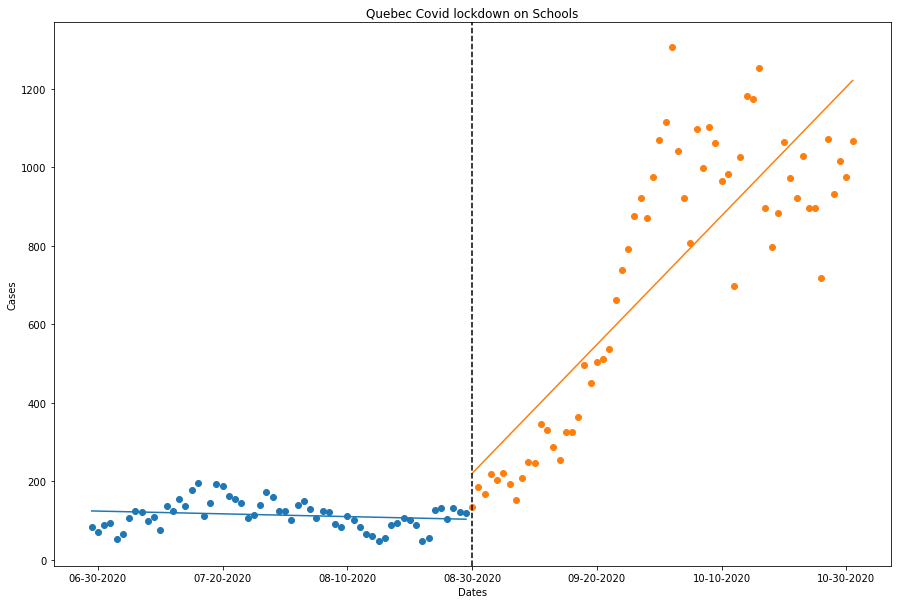

In [14]:
predictions_before = before.fittedvalues
predictions_after = after.fittedvalues

fig, ax = plt.subplots(figsize=(15,10))

# plot per and post lockdown
ax.scatter(X1[:,1]*-1, y)
ax.plot(X1[:,1]*-1, predictions_before)
ax.scatter(X2[:,1], y_after)
ax.plot(X2[:,1], predictions_after)

plt.xticks([-60,-40,-20,0,20,40,60],['06-30-2020', '07-20-2020','08-10-2020','08-30-2020','09-20-2020','10-10-2020','10-30-2020'])

# plot format
ax.set_title('Quebec Covid lockdown on Schools')
ax.set_ylabel('Cases')
ax.set_xlabel('Dates')
ax.axvline(0,color='black',alpha=1, ls = '--')

plt.show()

The P-value:

As shown above, the p-value is 0.000, which is less than 0.05, meaning we can reject the null hypothesis and conclude that the reopening of schools had a statistically significant effect on Covid cases.

The Coef:

As shown above, the coef is a positive value. Since the coefficient represents the average change in the response variable( in this case "Covid cases") associated with one-unit change with the predictor variable (in this case "the reopening of schools"), we can conclude that reopening increased the number of cases.

A justification on the design of your regression:

The DV is the number of daily cases, the IV is the amout of time before and after the reopening. We chose to add a month to the "before" and "after" because the virus has a 2 week incubation period, meaning some cases would not show up until the following month. We also chose to keep it simple and stick with a regular regression model for this particular case as the evidence is quite apparent and shows the effects of the reopening on the covid cases clearly.

# The second lockdown 12/25/2020

In [15]:
df = pd.read_csv('./pt/cases_pt.csv')
df['date'] = pd.to_datetime(df['date'])

In [16]:
#data found:
#https://github.com/ccodwg/CovidTimelineCanada/tree/main/data/pt


df = pd.read_csv('./pt/cases_pt.csv')
df = df.loc[df['region']=='QC']  #only looking at QC


#change date to only look at our interval
df['date'] = pd.to_datetime(df['date'])

start_date = '2020-11-24'
end_date = '2021-01-25'

period = (df['date']>start_date) &(df['date']<=end_date)
df = df.loc[period]

df

,name,region,date,value,value_daily
306,cases,QC,2020-11-25,128195,1275
307,cases,QC,2020-11-26,129624,1429
308,cases,QC,2020-11-27,130996,1372
309,cases,QC,2020-11-28,132410,1414
310,cases,QC,2020-11-29,133678,1268
...,...,...,...,...,...
363,cases,QC,2021-01-21,241245,1612
364,cases,QC,2021-01-22,242916,1671
365,cases,QC,2021-01-23,244416,1500
366,cases,QC,2021-01-24,245806,1390


In [17]:
#number each data point 30 days before and after the threshold
cutoff = datetime.strptime('2020-12-25',"%Y-%m-%d")
df['diff'] = df['date']-cutoff
df['diff']= df['diff'].astype('timedelta64[D]')
df

,name,region,date,value,value_daily,diff
306,cases,QC,2020-11-25,128195,1275,-30.0
307,cases,QC,2020-11-26,129624,1429,-29.0
308,cases,QC,2020-11-27,130996,1372,-28.0
309,cases,QC,2020-11-28,132410,1414,-27.0
310,cases,QC,2020-11-29,133678,1268,-26.0
...,...,...,...,...,...,...
363,cases,QC,2021-01-21,241245,1612,27.0
364,cases,QC,2021-01-22,242916,1671,28.0
365,cases,QC,2021-01-23,244416,1500,29.0
366,cases,QC,2021-01-24,245806,1390,30.0


In [18]:
#create a new column to assing 0 and 1 to create the two graphs to see before and after lockdown
df['threshold'] = None


#value 0 assigned to data before the threshold and values 1 assinged to values = to or above the threshold
pre_lockdown = df['diff'] < 0
post_lockdown = df['diff'] >= 0
df.loc[pre_lockdown, 'threshold'] = 0
df.loc[post_lockdown, 'threshold'] = 1
df


#if the lockdowns are working then the number of deaths should be going down
df.sample(10)

,name,region,date,value,value_daily,diff,threshold
308,cases,QC,2020-11-27,130996,1372,-28.0,0
336,cases,QC,2020-12-25,181696,2414,0.0,1
367,cases,QC,2021-01-25,246953,1147,31.0,1
351,cases,QC,2021-01-09,219285,2523,15.0,1
349,cases,QC,2021-01-07,213963,2650,13.0,1
343,cases,QC,2021-01-01,199114,2554,7.0,1
323,cases,QC,2020-12-12,154892,2004,-13.0,0
341,cases,QC,2020-12-30,193557,3100,5.0,1
338,cases,QC,2020-12-27,186074,2058,2.0,1
361,cases,QC,2021-01-19,238063,1374,25.0,1


In [19]:
#before lockdown
pre_lock = df[df['threshold']==0]
X_pre = np.array(pre_lock['diff']*-1)
X1_pre = sm.add_constant(X_pre)
y_pre = pre_lock['value_daily']
pre_lock = sm.WLS(y_pre, X1_pre).fit()
pre = pre_lock.fittedvalues
print(pre_lock.summary())

                            WLS Regression Results                            
Dep. Variable:            value_daily   R-squared:                       0.863
Model:                            WLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     177.0
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.26e-13
Time:                        20:28:02   Log-Likelihood:                -184.46
No. Observations:                  30   AIC:                             372.9
Df Residuals:                      28   BIC:                             375.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2255.3724     43.899     51.376      0.0

In [20]:
#after lockdown
post_lock = df[df['threshold']==1]
X_post = np.array(post_lock['diff'])
X1_post = sm.add_constant(X_post)
y_post = post_lock['value_daily']
post_lock = sm.WLS(y_post, X1_post).fit()
post = post_lock.fittedvalues
post = post_lock.fittedvalues
print(post_lock.summary())

                            WLS Regression Results                            
Dep. Variable:            value_daily   R-squared:                       0.597
Model:                            WLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     44.37
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           2.23e-07
Time:                        20:28:02   Log-Likelihood:                -228.87
No. Observations:                  32   AIC:                             461.7
Df Residuals:                      30   BIC:                             464.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2745.5568    110.234     24.907      0.0

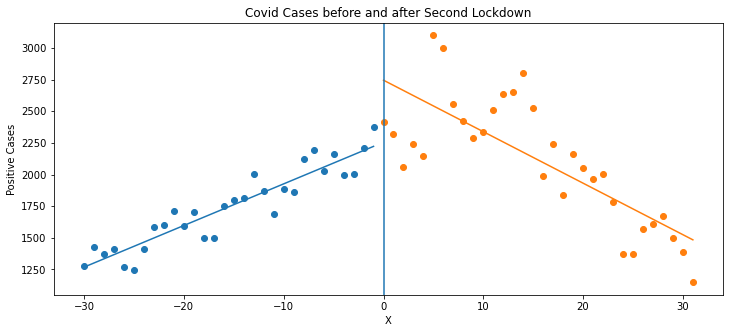

In [21]:
fig, ax = plt.subplots(figsize=(12,5))

#left side
ax.scatter(X1_pre[:,1]*-1, y_pre)
ax.plot(X1_pre[:,1]*-1, pre)
#right side 
ax.scatter(X1_post[:,1], y_post)
ax.plot(X1_post[:,1], post)


ax.set_title('Covid Cases before and after Second Lockdown')
ax.set_ylabel('Positive Cases')
ax.set_xlabel('X')
ax.axvline()
plt.show()

The parameter chosen as the cut off point is the date of the second lockdown 25/12/2020. In our summary tables the p-value is displays 0.000, which is statitically significant because its bellow 0.05, meaning the null hypothesis can be rejected. Our null hypothesis here would be that a second lockdown would not have an effect on the number of covid cases.

In both cases pre and post lockdown, the coefficients are negative, suggesting that as the predictor variable increases, the response variable decreases. In our case the response varibale is the number of cases.

In conclusion, we can see that he 20/3/2020 lockdown, the reopening of schools on 31/8/2020, and the 25/12/2020 lockdown all had an effect on the number of Covid cases in Quebec. Starting with the 20/3/2020 lockdown, it's clear that there was still a steady increase in the number of cases, however this increase could have been much more severe if the lockdown was not put in place.

This is shown in the next example with the reopening of schools. We can see a significant increase in the rate at which covid cases increased per day after the schools reopened. This leads us to conclude that not only did the reopening of schools had a significant stastitical increase on the number of covid cases, but that the 20/3/2020 lockdown possibly decreased the number of cases. We reach this conclusion by seeing how drastically the reopening had an impact, so we can assume that the lockdown had an inverse effect, at least to a certain degree.

Again we see an increase in cases leading up the the 2nd lockdown, and once the second lockdown was in place the cases start to decrease once more.